In [133]:
import metaworld
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# from models import encoder, policy

In [10]:
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__25:10_21:13:08'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [15]:
ml1 = metaworld.ML1('pick-place-v2')
env = ml1.train_classes['pick-place-v2']()
task = random.choice(ml1.train_tasks)
env.set_task(task)

In [62]:

ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs = dict()
for name, env_cls in ml10.train_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.train_tasks
                        if task.env_name == name])
  env.set_task(task)
  training_envs[name] = env

In [198]:
NUM_EPISODES = 10
environments = training_envs # testing_envs
episode_log = {env_name:{'episode_len': [],'episode_reward': [], 'successes':[]} for env_name in environments.keys()}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for env_name, env in environments.items():

    for episode in range(NUM_EPISODES):
        obs, _ = env.reset()
        # reset encoder to prior
        latent_sample, latent_mean, latent_logvar, hidden_state = encoder_net.prior(1)
        done = False

        episode_reward = 0
        episode_steps = 0
        success = 0

        while not done:
        # reset
            # get latent for policy
            latent_sample = F.relu(latent_sample)
            latent_mean = F.relu(latent_mean)
            latent_logvar = F.relu(latent_logvar)
            latent = torch.cat((latent_mean, latent_logvar), dim=-1).reshape(1, -1)

            # if latent.shape[0] == 1:
            #     latent = latent.squeeze(0)
            # latent

            _, act = policy_net.act(obs, latent, None, None)
            # print(act)
            action = act.cpu().detach().numpy()[0]
            # print(action)
            next_obs, reward, terminated, truncated, info = env.step(action)
            obs = next_obs
            done = terminated or truncated
            episode_reward += reward
            episode_steps += 1
            success += info['success']


            ### TODO: can you accumulate the history of past rewards, actions and states 
            ### check how this was done in the evaluate script
            latent_sample, latent_mean, latent_logvar, hidden_state = encoder_net(
                actions = act.float(),
                states = torch.from_numpy(np.append(next_obs, 0)).float()[None,].to(device),
                rewards = torch.from_numpy(np.array(reward)).float()[None,None,].to(device),
                hidden_state=hidden_state,
                return_prior=False
            )

            if info['success'] > 0:
                print(f'SUCCESS!! {env_name}')
                done = True
        
        # record results
        episode_log[env_name]['episode_reward'].append(episode_reward)
        episode_log[env_name]['episode_len'].append(episode_steps)
        episode_log[env_name]['successes'].append(success)



SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! drawer-close-v2
SUCCESS!! window-open-v2
SUCCESS!! window-open-v2
SUCCESS!! window-open-v2
SUCCESS!! window-open-v2
SUCCESS!! window-open-v2
SUCCESS!! window-open-v2


In [199]:
import pandas as pd
df = pd.DataFrame(episode_log)
df

,reach-v2,push-v2,pick-place-v2,door-open-v2,drawer-close-v2,button-press-topdown-v2,peg-insert-side-v2,window-open-v2,sweep-v2,basketball-v2
episode_len,"[500, 500, 500, 500, 500, 500, 500, 500, 500, ...","[500, 500, 500, 500, 500, 500, 500, 500, 500, ...","[500, 500, 500, 500, 500, 500, 500, 500, 500, ...","[500, 500, 500, 500, 500, 500, 500, 500, 500, ...","[25, 28, 23, 28, 24, 41, 22, 32, 500, 471]","[500, 500, 500, 500, 500, 500, 500, 500, 500, ...","[500, 500, 500, 500, 500, 500, 500, 500, 500, ...","[113, 500, 134, 177, 132, 146, 137, 500, 500, ...","[500, 500, 500, 500, 500, 500, 500, 500, 500, ...","[500, 500, 500, 500, 500, 500, 500, 500, 500, ..."
episode_reward,"[1800.9663491901988, 1665.6774443873426, 1496....","[7.548240903225013, 7.448631923875689, 8.54242...","[1.9993370223738811, 1.9191299130974364, 1.807...","[1101.679507796949, 392.3065731962873, 1096.26...","[14.510906408344862, 12.583863574683038, 11.11...","[1018.216874871643, 1055.1797362026566, 678.01...","[2.481631295551131, 2.5364862750388637, 2.4528...","[260.46466626705273, 297.8774126415376, 150.34...","[13.169987453434333, 13.258762981374076, 13.35...","[2.0402135498638887, 1.9735492871846563, 2.049..."
successes,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [82]:
df.index[1]

'episode_reward'

In [84]:
list(zip(df.columns, df.iloc[0]))

[('reach-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('push-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('pick-place-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('door-open-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('drawer-close-v2', [500, 500, 28, 51, 27, 49, 500, 500, 500, 500]),
 ('button-press-topdown-v2',
  [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('peg-insert-side-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('window-open-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('sweep-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 ('basketball-v2', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500])]

In [89]:
df.index[1]*10

'episode_rewardepisode_rewardepisode_rewardepisode_rewardepisode_rewardepisode_rewardepisode_rewardepisode_rewardepisode_rewardepisode_reward'

In [200]:

unpacked = pd.concat(
    [pd.DataFrame(dict(zip(df.columns,  df.iloc[i])), index=[df.index[i] for _ in range(df.shape[1])]) for i in range(len(df))]
).reset_index().melt(id_vars='index')

<Axes: xlabel='value', ylabel='Count'>

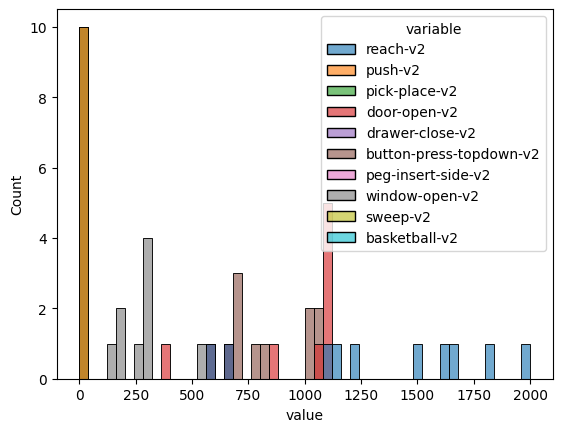

In [204]:
import seaborn as sns

sns.histplot(
    data = unpacked.query('index=="episode_reward"'),
    x = 'value',
    # y = 'iter',
    hue='variable',
    alpha = 0.63,
    bins = 50
)

In [207]:
unpacked.query('index=="episode_reward"')

,index,variable,value
10,episode_reward,reach-v2,1800.966349
11,episode_reward,reach-v2,1665.677444
12,episode_reward,reach-v2,1496.570743
13,episode_reward,reach-v2,1214.961464
14,episode_reward,reach-v2,2000.677301
...,...,...,...
285,episode_reward,basketball-v2,2.017340
286,episode_reward,basketball-v2,2.032561
287,episode_reward,basketball-v2,2.035991
288,episode_reward,basketball-v2,2.082787


In [70]:
[(env_name, episode_log[env_name]['episode_reward'], episode_log[env_name]['successes']) for env_name in environments.keys()]

[('reach-v2',
  [667.1301443128568,
   1057.1948481354677,
   687.8670528991827,
   718.4167685842915,
   698.6488927887088,
   922.6711523477588,
   931.8354395041831,
   949.67222461397,
   1174.5043263176171,
   806.0440956085325],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('push-v2',
  [7.558540359908726,
   7.669564252934451,
   7.378728367928656,
   7.247409933493489,
   6.702880100556234,
   7.889638923816483,
   7.096033507862574,
   7.038036443038129,
   8.383475629030148,
   6.903279933363616],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('pick-place-v2',
  [5.107230758754558,
   4.2586001639766975,
   5.045404568109512,
   4.0105719899433305,
   4.161394564161164,
   4.665740379139667,
   3.9354686901053806,
   3.5521182568597713,
   4.527171399566086,
   4.21783349163485],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('door-open-v2',
  [559.0440222310818,
   543.7618671053145,
   313.11369404394446,
   343.921087197201,
   335.1271129490

(array([1., 1., 3., 2., 0., 0., 1., 0., 1., 1.]),
 array([2.62942637, 2.76197471, 2.89452305, 3.02707138, 3.15961972,
        3.29216806, 3.4247164 , 3.55726473, 3.68981307, 3.82236141,
        3.95490974]),
 <BarContainer object of 10 artists>)

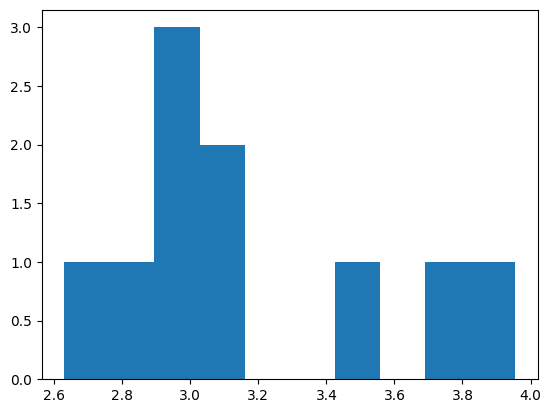

In [56]:
plt.hist(episode_log['episode_reward'])

(array([3., 0., 3., 2., 0., 0., 0., 0., 1., 1.]),
 array([2.73508128, 2.80469129, 2.8743013 , 2.94391131, 3.01352133,
        3.08313134, 3.15274135, 3.22235137, 3.29196138, 3.36157139,
        3.43118141]),
 <BarContainer object of 10 artists>)

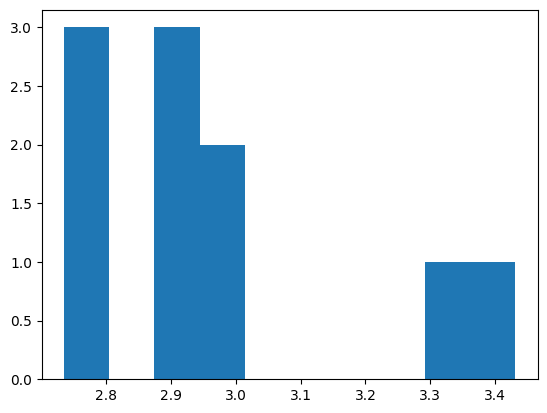

In [54]:

plt.hist(episode_log['episode_reward'])

(array([ 5.85813967e-03,  6.00190770e-01,  1.93838262e-01,  1.00000000e+00,
         3.56150095e-03,  6.57002988e-01,  1.99122858e-02,  2.52285572e-04,
         2.36441893e-04, -6.92270859e-09,  9.99999940e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.15235164e-03,  6.00189803e-01,
         1.94301175e-01,  1.00000000e+00,  3.55250956e-03,  6.57012590e-01,
         1.99999996e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 0.020261069174293874,
 False,
 False,
 {'success': 0.0,
  'near_object': 0.0,
  'grasp_success': 0.0,
  'grasp_reward': 0.022413716205175134,
  'in_place_reward': 0.17420998086761091,
  'obj_to_target': 0.18219310390530946,
  'unscaled_reward': 0.0202610

In [25]:
print(latent_sample.size(), latent_mean.size(), latent_logvar.size(), hidden_state.size())

torch.Size([1, 1, 128]) torch.Size([1, 1, 128]) torch.Size([1, 1, 128]) torch.Size([1, 1, 128])


In [22]:
encoder_net(
    actions = ,
    states = obs,
    rewards = rew,
    hidden_state = ,
    return_prior = True #?
)

TypeError: forward() missing 1 required positional argument: 'return_prior'